In [1]:
import xarray as xr
import numpy as np

# Load the 4D SINMOD dataset
ds = xr.open_dataset("/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc")

# Check the dataset structure
print(ds)

# List of variables for processing
variables = ['temperature', 'salinity', 'u_velocity', 'v_velocity']


<xarray.Dataset> Size: 157GB
Dimensions:          (time: 365, dummySampleDim: 6, zc: 50, xc: 950, yc: 555)
Coordinates:
    time             (time, dummySampleDim) int32 9kB ...
  * xc               (xc) float32 4kB 800.0 1.6e+03 ... 7.592e+05 7.6e+05
  * yc               (yc) float32 2kB 800.0 1.6e+03 ... 4.432e+05 4.44e+05
  * zc               (zc) float32 200B 3.0 6.0 10.0 ... 2.5e+03 2.75e+03 3e+03
Dimensions without coordinates: dummySampleDim
Data variables:
    grid_mapping     int32 4B ...
    LayerDepths      (zc) float32 200B ...
    depth            (yc, xc) float32 2MB ...
    DXxDYy           (yc, xc) float32 2MB ...
    u_velocity       (time, zc, yc, xc) float32 38GB ...
    v_velocity       (time, zc, yc, xc) float32 38GB ...
    elevation        (time, yc, xc) float32 770MB ...
    temperature      (time, zc, yc, xc) float32 38GB ...
    salinity         (time, zc, yc, xc) float32 38GB ...
    ice_thickness    (time, yc, xc) float32 770MB ...
    ice_compactness  (time

In [ ]:
import xarray as xr
import dask
import time 

def process_bottom_layer(
    file_path,
    variable_name,
    chunks={"time":-1, "zc": -1, "yc": 50, "xc": 50},
    output_path=None
):
    """
    Process bottom layer data for a specified variable in a NetCDF file.
    
    Parameters:
    - file_path (str): Path to the NetCDF file.
    - variable_name (str): Name of the variable to process.
    - chunks (dict): Chunking strategy for the dataset.
    - slice_dict (dict): Slicing parameters for the data (e.g., {"zc": slice(0, 10), "yc": slice(0, 10), "xc": slice(65, 75)}).
    - output_path (str): Path to save the processed file (optional). If None, the result is not saved.
    
    Returns:
    - xarray.DataArray: The time-averaged bottom layer data.
    """
    time_start = time.time()

    # Open the dataset with chunking
    ds = xr.open_dataset(file_path, chunks=chunks)

    print(f"\nAccessed the dataset in {time.time() - time_start:.2f} seconds")
    
    # Extract the variable
    if variable_name == "current_speed":
        data_var = ds["u_velocity"]
    else:
        data_var = ds[variable_name]
    
    # Extract the first time step
    time_slice = data_var.isel(time=0)
    
    # Step 1: Create a mask for valid values in first time step
    valid_mask = ~time_slice.isnull()
    
    # Step 2: Find the index of the bottom-most valid layer for each (yc, xc)
    # Subtract 1 to get the correct index for the bottom layer
    bottom_layer_idx = valid_mask.argmin(dim="zc") - 1

    # Ensure bottom_layer_idx does not go negative (e.g., if all values are invalid in a column)
    bottom_layer_idx = bottom_layer_idx.clip(min=0)
    
    # Step 3: Extract the bottom layer data across all time steps
    if variable_name == "current_speed":
        bottom_layer_data = (data_var.isel(zc=bottom_layer_idx)**2 + ds["v_velocity"].isel(zc=bottom_layer_idx)**2)**0.5
    else:
        bottom_layer_data = data_var.isel(zc=bottom_layer_idx.load())

    print(f"\nExtracted the bottom layer data in {time.time() - time_start:.2f} seconds.\n\nStarting computation of statistics...")

    # CONSIDER CHUNKING THE BOTTOM LAYER DATA FOR EFFICIENT COMPUTATION
    # bottom_layer_data = bottom_layer_data.chunk({"yc": 50, "xc": 50})

    # Step 4: Calculate statistics across time
    time_avg_bottom_layer = bottom_layer_data.mean(dim="time", skipna=True)

    # Calculate both 10th and 90th percentiles
    time_percentiles = bottom_layer_data.quantile([0.1, 0.9], dim="time", skipna=True)

    print(f"\nComputed statistics after {time.time() - time_start:.2f} seconds")

    # Create a new DataArray with the (mean, 10th, 90th) percentiles and explicitly define the 'stat' dimension
    # Concatenate mean and percentiles in one line, drop 'quantile' and concatenate all together
    stats_array = xr.concat([time_avg_bottom_layer, time_percentiles.sel(quantile=0.1).drop_vars("quantile"), time_percentiles.sel(quantile=0.9).drop_vars("quantile")], dim="stat").rename(f"{variable_name}_features")

    # Name each value of the first dimension
    stats_array = stats_array.assign_coords(stat=["mean", "10th_percentile", "90th_percentile"])
    # Save to output file if specified
    if output_path:
        stats_array.to_netcdf(output_path)
    
    return stats_array, bottom_layer_idx

In [45]:
speed_array, idx = process_bottom_layer("/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc", "current_speed")
speed_array

/cluster/home/haroldh/.conda/envs/SINMOD/lib/python3.12/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "yc" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
/cluster/home/haroldh/.conda/envs/SINMOD/lib/python3.12/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "xc" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)



Accessed the dataset in 0.01 seconds


ValueError: Vectorized indexing with Dask arrays is not supported. Please pass a numpy array by calling ``.compute``. See https://github.com/dask/dask/issues/8958.

In [1]:
import xarray as xr
import time 

def process_bottom_layer_no_dask(
    file_path,
    variable_name,
    #chunks={"time":-1, "zc": -1, "yc": 50, "xc": 50},
    output_path=None
):
    """
    Process bottom layer data for a specified variable in a NetCDF file.
    
    Parameters:
    - file_path (str): Path to the NetCDF file.
    - variable_name (str): Name of the variable to process.
    - chunks (dict): Chunking strategy for the dataset.
    - slice_dict (dict): Slicing parameters for the data (e.g., {"zc": slice(0, 10), "yc": slice(0, 10), "xc": slice(65, 75)}).
    - output_path (str): Path to save the processed file (optional). If None, the result is not saved.
    
    Returns:
    - xarray.DataArray: The time-averaged bottom layer data.
    """
    time_start = time.time()

    # Open the dataset
    ds = xr.open_dataset(file_path)

    print(f"\nAccessed the dataset after {time.time() - time_start:.2f} seconds")
    
    # Extract the variable
    if variable_name == "current_speed":
        data_var = ds["u_velocity"][:,:,0:10,65:75]
    else:
        data_var = ds[variable_name]
    
    # Extract the first time step
    time_slice = data_var.isel(time=0)
    
    # Step 1: Create a mask for valid values in first time step
    valid_mask = ~time_slice.isnull()
    
    # Step 2: Find the index of the bottom-most valid layer for each (yc, xc)
    # Subtract 1 to get the correct index for the bottom layer
    bottom_layer_idx = valid_mask.argmin(dim="zc") - 1

    # Ensure bottom_layer_idx does not go negative (e.g., if all values are invalid in a column)
    bottom_layer_idx = bottom_layer_idx.clip(min=0)
    
    # Step 3: Extract the bottom layer data across all time steps
    if variable_name == "current_speed":
        bottom_layer_data = (data_var.isel(zc=bottom_layer_idx)**2 + ds["v_velocity"][:,:,:10,65:75].isel(zc=bottom_layer_idx)**2)**0.5
    else:
        bottom_layer_data = data_var.isel(zc=bottom_layer_idx)

    ds.close()

    print(f"\nExtracted the bottom layer data after {time.time() - time_start:.2f} seconds.\n\nStarting computation of statistics...")

    # Step 4: Calculate statistics across time
    time_avg_bottom_layer = bottom_layer_data.mean(dim="time", skipna=True)

    # Calculate both 10th and 90th percentiles
    time_percentiles = bottom_layer_data.quantile([0.1, 0.9], dim="time", skipna=True)

    print(f"\nComputed statistics after {time.time() - time_start:.2f} seconds")

    # Create a new DataArray with the (mean, 10th, 90th) percentiles and explicitly define the 'stat' dimension
    # Concatenate mean and percentiles in one line, drop 'quantile' and concatenate all together
    stats_array = xr.concat([time_avg_bottom_layer, time_percentiles.sel(quantile=0.1).drop_vars("quantile"), time_percentiles.sel(quantile=0.9).drop_vars("quantile")], dim="stat").rename(f"{variable_name}_features")

    # Name each value of the first dimension
    stats_array = stats_array.assign_coords(stat=["mean", "10th_percentile", "90th_percentile"])

    # Save to output file if specified
    if output_path:
        stats_array.to_netcdf(output_path)
    
    return stats_array, bottom_layer_idx

In [2]:
current_array_loaded, idx_no_dask = process_bottom_layer_no_dask("/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc", "temperature")


Accessed the dataset after 0.51 seconds

Extracted the bottom layer data after 8.14 seconds.

Starting computation of statistics...


/cluster/home/haroldh/.conda/envs/SINMOD/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1650: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,



Computed statistics after 243.53 seconds


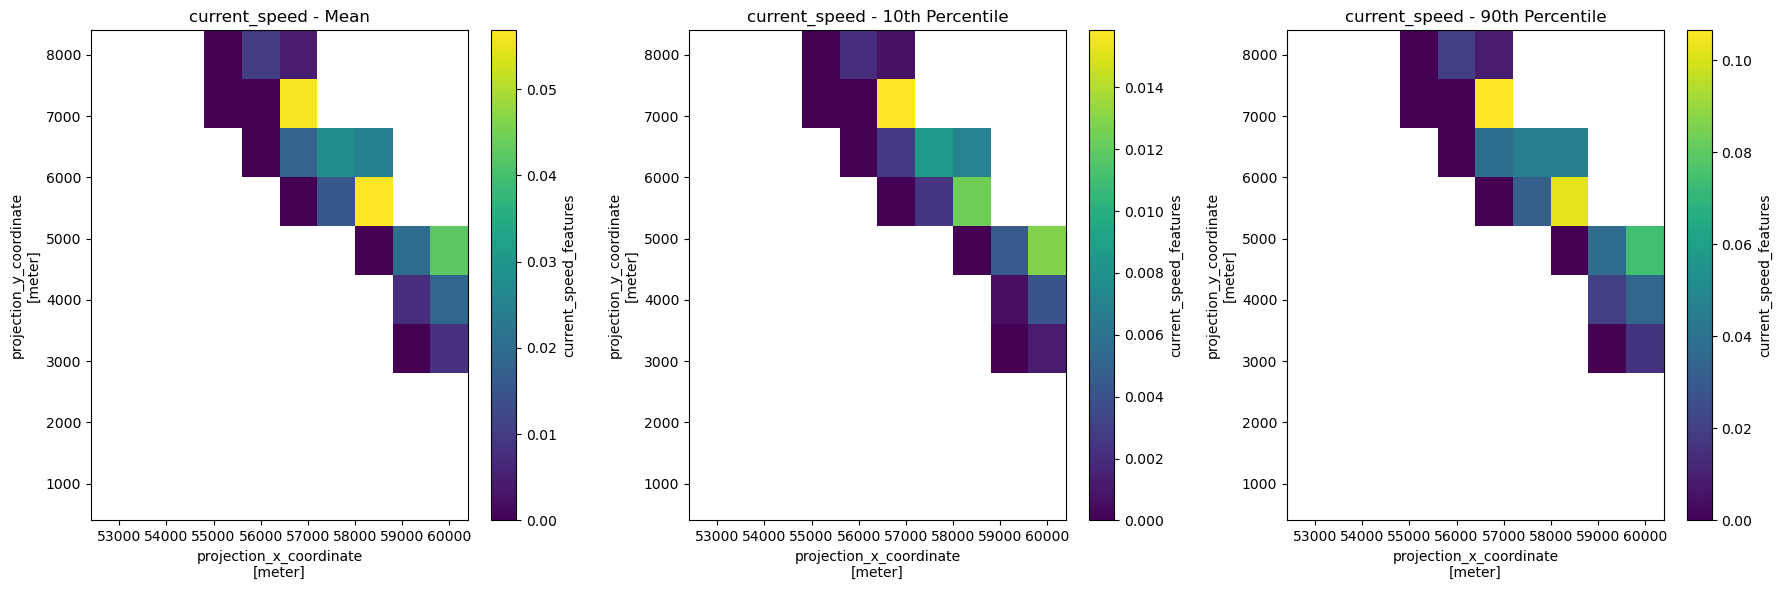

In [5]:
import matplotlib.pyplot as plt

variable_name = "current_speed"
data_array = current_array_loaded

# Visualize the results for the entire data
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot mean, 10th percentile, and 90th percentile for the entire dataset
data_array.sel(stat="mean").plot(ax=axes[0])
axes[0].set_title(f'{variable_name} - Mean')

data_array.sel(stat="10th_percentile").plot(ax=axes[1])
axes[1].set_title(f'{variable_name} - 10th Percentile')

data_array.sel(stat="90th_percentile").plot(ax=axes[2])
axes[2].set_title(f'{variable_name} - 90th Percentile')

plt.tight_layout()
plt.show()


In [42]:
import numpy as np

data_slice = temp_array_no_dask.isel(xc=slice(65, 75), yc=slice(0, 10))

# 1. Assert that if one of the statistics is NaN, then all three (mean, 10th, 90th percentiles) should also be NaN
nan_mask = data_slice.sel(stat="mean").isnull() | data_slice.sel(stat="10th_percentile").isnull() | data_slice.sel(stat="90th_percentile").isnull()
assert (nan_mask == (data_slice.sel(stat="mean").isnull() & data_slice.sel(stat="10th_percentile").isnull() & data_slice.sel(stat="90th_percentile").isnull())).all(), "If one of the stats is NaN, all of them should be NaN for that grid point."

# 2. Assert that the mean should be greater than or equal to the 10th percentile, and less than or equal to the 90th percentile, ignoring NaNs
assert (data_slice.sel(stat="mean").notnull() >= data_slice.sel(stat="10th_percentile").notnull()).all(), "Mean should be greater than or equal to the 10th percentile"
assert (data_slice.sel(stat="mean").notnull() <= data_slice.sel(stat="90th_percentile").notnull()).all(), "Mean should be less than or equal to the 90th percentile"


In [40]:
data_slice.where(~nan_mask)

<xarray.DataArray 'temperature_features' (stat: 3, yc: 10, xc: 10)> Size: 1kB
array([[[       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,  9.276141 ,  9.502221 ],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,  9.276451 ,  9.27562  ],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,  9.294881 ,  9.278977 ,  9.501853 ],
        [       nan,        nan,        nan,        nan,        nan,
          9.248645 ,  9.263824 ,  9.282894 ,        nan,        nan],
        [       nan,        nan,        nan,        nan, 10.341753 ,
          9.235967 ,  9.264755 ,  9.2834215,        nan,        nan],
        [       nan,        nan,        nan,  9.960108 ,  9.083278 ,
          9.209288 ,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,  9.487622 ,  9.073619 ,
          9.075063 ,        nan,        nan,        nan,        nan]],
...
                nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan, 10.483999 , 10.727281 ],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan, 10.483841 , 10.484793 ],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan, 10.486856 , 10.485904 , 10.703476 ],
        [       nan,        nan,        nan,        nan,        nan,
         10.41449  , 10.440199 , 10.46924  ,        nan,        nan],
        [       nan,        nan,        nan,        nan, 13.935484 ,
         10.401794 , 10.444642 , 10.468447 ,        nan,        nan],
        [       nan,        nan,        nan, 12.396131 , 10.166765 ,
         10.372436 ,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan, 10.959454 , 10.153276 ,
         10.158989 ,        nan,        nan,        nan,        nan]]],
      dtype=float32)
Coordinates:
  * xc       (xc) float32 40B 5.28e+04 5.36e+04 5.44e+04 ... 5.92e+04 6e+04
  * yc       (yc) float32 40B 800.0 1.6e+03 2.4e+03 ... 6.4e+03 7.2e+03 8e+03
    zc       (yc, xc) float32 400B 3.0 3.0 3.0 3.0 3.0 ... 100.0 3.0 3.0 3.0 3.0
  * stat     (stat) <U15 180B 'mean' '10th_percentile' '90th_percentile'